<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/GANs_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GANs - Generative Adversarial Networks

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. 

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization.

ref: [Generating Images using Generative Adversarial Networks](https://jovian.ai/aakashns/06b-anime-dcgan)

####Import Libraries

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import os
import opendatasets as od

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

In [3]:
palette = sns.cubehelix_palette(start=.5, rot=-.5)
sns.set_palette(palette = palette)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.max_open_warning'] = 1
plt.rc('figure', titlesize = 18)

####Import Dataset
> Abstract Art Dataset from Kaggle

In [4]:
od.download("https://www.kaggle.com/bryanb/abstract-art-gallery/code?datasetId=742030&sortBy=voteCount")
image_folder = r"/content/abstract-art-gallery"

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: satorumi
Your Kaggle Key: ··········


100%|██████████| 693M/693M [00:05<00:00, 132MB/s]


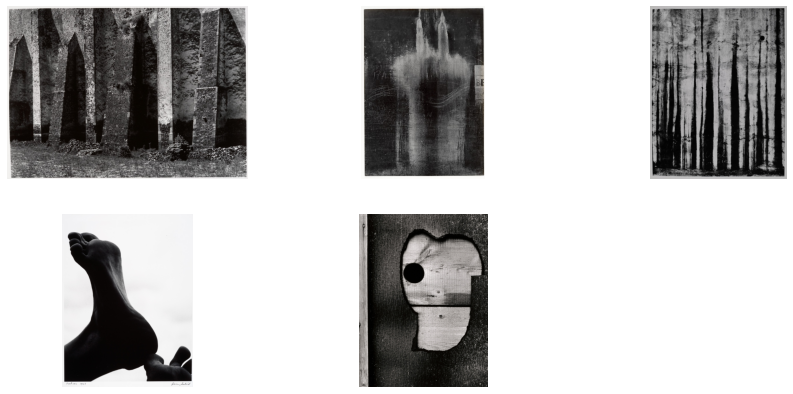

In [5]:
n_examples = 5
for i in range(n_examples):
  plt.subplot(2, np.ceil(n_examples / 2), i+1)
  dir = f"/content/abstract-art-gallery/Abstract_gallery/Abstract_gallery/Abstract_image_{i}.jpg"
  plt.imshow(plt.imread(dir))
  plt.axis("off")

In [6]:
plt.imread(dir).shape

(941, 700, 3)

###Preprocessing Dataset
Load this dataset using the ImageFolder class from torchvision. Resize and normalize images' pixels value. Then, create a dataloader

Define device

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Load and transform data

In [8]:
image_size = 128
batch_size = 128
img_stats = (.5, .5, .5), (.5, .5, .5)

In [9]:
transformations = transforms.Compose([
                    # resize all image to the same size                                              
                    transforms.Resize((image_size, image_size)),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(), # convert to tensor obj
                    # normalize pixel with computed stats
                    transforms.Normalize(*img_stats)
                                    ])

In [10]:
def denorm(img_tensor):
    return img_tensor * img_stats[1][0] + img_stats[0][0]

#### Create DataLoader

In [11]:
dataset = ImageFolder(image_folder, transform=transformations)

dataloader = DataLoader(dataset, batch_size, shuffle=True)

Explore And Visualize Data

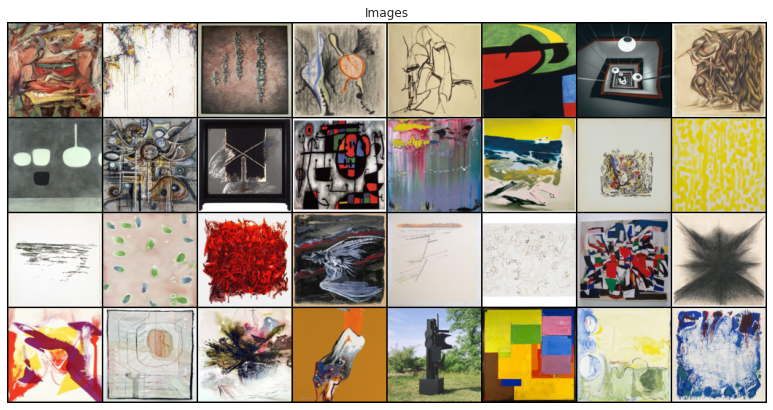

In [12]:
img, _ = next(iter(dataloader))
plt.axis("off")
plt.title("Images")
plt.imshow(torchvision.utils.make_grid(denorm(img.detach()[:32]), nrow=8).permute(1, 2, 0))

### Build GANs Model

####Discriminator Model
The discriminator takes an image as input, and tries to classify it as "real" or "generated"

In [13]:
# Define Discriminator model with Convolutional Network
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.classification = nn.Sequential(
        # input size 128 x 3 x 128 x 128
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # out 64
        nn.BatchNorm2d(64),
        # leaky relu level layer return very small output for negative value
        nn.LeakyReLU(0.2, inplace=True), # size: 128 x 64 x 64 x 64

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True), # size: 128 x 128 x 32 x 32

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True), # size: 128 x 256 x 16 x 16

        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True), # size: 128 x 512 x 8 x 8

        nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2, inplace=True), # size: 128 x 1024 x 4 x 4

        nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Flatten(), # 128 x 1 x 1 x 1
        nn.Sigmoid() # binary classification
    )

  def forward(self, X):
    return self.classification(X)

In [14]:
discriminator_model = Discriminator().to(device)

####Generator Model
The input to the generator is typically a vector or a matrix of random numbers (`latent tensor`) which is used as a initial input for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To acheive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (or deconvolution). 

[Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

In [15]:
latent_size = 128

In [16]:
class Generator(nn.Module):
  def __init__(self, latent_size):
    super(Generator, self).__init__()
    
    self.generate = nn.Sequential(
        # input size: latent_size x 1 x 1

        nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True), # size: 128 x 1024 x 4 x 4

        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True), # size: 128 x 512 x 8 x 8

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True), # size 128 x 256 x 16 x 16

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True), # size 128 x 128 x 32 x 32

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True), # size 128 x 64 x 64 x 64

        # output layer: size 128 x 3 x 128 x 128
        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh() # activation function range val from -1 -> 1
    )

  def forward(self, X):
    return self.generate(X)

In [17]:
generator_model = Generator(latent_size).to(device)

In [18]:
generator_model

Generator(
  (generate): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

torch.Size([128, 3, 128, 128])


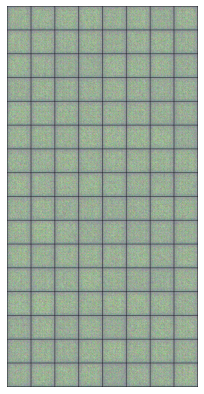

In [19]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device) # random latent tensors

generated_img = generator_model(fixed_latent)
print(generated_img.shape)
plt.axis("off")
plt.imshow(torchvision.utils.make_grid(denorm(generated_img)).cpu().permute(1, 2, 0))

###Training Models

Define optimizers for each of the model and loss function

In [25]:
lr_d = 10e-5
lr_g = 10e-4
d_optim = torch.optim.Adam(discriminator_model.parameters(), lr_d)
g_optim = torch.optim.Adam(generator_model.parameters(), lr_g)

loss_fn = nn.BCELoss()



####Steps involved in training the discriminator.

We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

1. We first pass a batch of real images, and compute the loss, setting the target labels to 1.

2. Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

3. Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

In [26]:
def train_discriminator(real_img, discriminator_model, generator_model, d_optimizer, g_optimizer): 
  d_optimizer.zero_grad()

  # passin real imgs in discrimininator model and get classfied results
  dis_pred = discriminator_model(real_img)
  real = torch.ones(real_img.size(0), 1).to(device) # 1 represent real img
  real_loss = loss_fn(dis_pred, real)

  # generate a latent and img from generator, pass in discriminator and compute loss
  latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
  generated_img = generator_model(latent)
  dis_pred = discriminator_model(generated_img)
  generated = torch.zeros(generated_img.size(0), 1).to(device) # 0 represent generated img
  generate_loss = loss_fn(dis_pred, generated)

  # overall loss
  loss = real_loss + generate_loss
  loss.backward()

  d_optimizer.step()

  return real_loss, generate_loss, loss

use the binary cross entropy loss function to evaluate the loss of binary classification

####Steps invlove in Generator Training
1. We generate a batch of images using the generator, pass the into the discriminator.

2. We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

3. We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [27]:
def train_generator(discriminator_model, generator_model, d_optimizer, g_optimizer):
  g_optimizer.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1, 1).to(device) # a random lantent
  generated_img = generator_model(latent)
  # classified the generated img
  dis_pred = discriminator_model(generated_img)

  # compare with real img to get the loss as we want the fake to be classified as real
  generator_loss = loss_fn(dis_pred, real)

  generator_loss.backward()

  g_optimizer.step()

  return generator_loss, generated_img

####Training Process

In [34]:
n_batch = len(dataloader)
datasize = len(dataloader.dataset)

# tracking the process and storing history

d_losses = {"generate": [], "real": [], "total": []}
g_losses = []
generated_imgs = []

g_path = "GANS_generator.ckpt"
d_path = "GANS_discriminator.ckpt"
epochs = 3

In [ ]:
for epoch in range(epochs):
  print(f'Epoch {epoch+1}\n-------------------------------')
  total_g = 0.
  total_d, d_real, d_generate = 0., 0., 0.

  for batch, (images, _ ) in enumerate(dataloader):
    images = images.to(device)
    # train the discrimninator with batch of imgs
    real_score, fake_score, d_loss = train_discriminator(images, discriminator_model, generator_model, d_optim, g_optim)
    
    # train the generator
    g_loss, generated_img = train_generator(discriminator_model, generator_model, d_optim, g_optim)
    
    # print result for every 5 min-batches
    if batch % 5 == 0:
      print(f"Discriminator Loss: {d_loss:>4f}, Generator Loss: {g_loss:>4f}  [{(batch+1) * len(images):>5d}/{datasize*n_batch:>5d}]")
    
    total_g += g_loss
    total_d += d_loss
    d_real += real_score
    d_generate += fake_score
  
  # compute the mean stats for each epoch
  d_losses["total"].append((total_d / n_batch))
  d_losses["real"].append((d_real / n_batch))
  d_losses["generate"].append((d_generate / n_batch))
  g_losses.append((total_g / n_batch))
   # save a sample of generator img
  generated_imgs.append(generated_img)

  torch.save(discriminator_model.state_dict(), d_path)
  torch.save(generator_model.state_dict(), g_path)

Epoch 1
-------------------------------
Discriminator Loss: 0.790929, Generator Loss: 6.335179  [  128/66056]
Discriminator Loss: 0.682889, Generator Loss: 5.066936  [  768/66056]
Discriminator Loss: 0.431716, Generator Loss: 6.241662  [ 1408/66056]
Discriminator Loss: 0.617400, Generator Loss: 8.413049  [ 2048/66056]
Discriminator Loss: 0.668891, Generator Loss: 8.511823  [ 2688/66056]
Epoch 2
-------------------------------
Discriminator Loss: 0.524816, Generator Loss: 6.350037  [  128/66056]
Discriminator Loss: 0.596018, Generator Loss: 5.469519  [  768/66056]
Discriminator Loss: 0.528593, Generator Loss: 5.556034  [ 1408/66056]
Discriminator Loss: 0.389326, Generator Loss: 4.556002  [ 2048/66056]
Discriminator Loss: 0.230336, Generator Loss: 4.813153  [ 2688/66056]
Epoch 3
-------------------------------
Discriminator Loss: 0.320972, Generator Loss: 5.551575  [  128/66056]
Discriminator Loss: 0.152967, Generator Loss: 6.646002  [  768/66056]
Discriminator Loss: 0.123276, Generator 

#### Full Training Implementation

In [ ]:
def fit(epochs, d_lr, g_lr, dataloader, latent_size = 128):
  torch.cuda.empty_cache()

  discriminator_model = Discriminator().to(device)
  generator_model = Generator(latent_size).to(device)

  n_batch = len(dataloader)
  datasize = len(dataloader.dataset)

  d_losses = {"generate": [], "real": [], "total": []}
  g_losses = []

  d_optim = torch.optim.Adam(discriminator_model.parameters(), d_lr)
  g_optim = torch.optim.Adam(generator_model.parameters(), g_lr)

  loss_fn = nn.BCELoss()
  real = torch.ones(image_size, 1).to(device) 
  generated = torch.zeros(image_size, 1).to(device) 

  for epoch in range(epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')

    total_g = 0.
    total_d, d_real, d_generate = 0., 0., 0.

    for batch, (images, _ ) in enumerate(data_loader):
      images = images.to(device)
      real_score, fake_score, d_loss = train_discriminator(images, discriminator_model, generator_model, d_optim, g_optim)
      g_loss, generated_img = train_generator(discriminator_model, generator_model, d_optim, g_optim)

      if batch % 5 == 0:
        print(f"Discriminator Loss: {d_loss:>4f}, Generator Loss: {g_loss:>4f}  [{(batch+1) * len(images):>5d}/{datasize*n_batch:>5d}]")
    
      total_g += g_loss
      total_d += d_loss
      d_real += real_score
      d_generate += fake_score

    generated_imgs.append(generated_img) 

    d_losses["total"].append((total_d / n_batch))
    d_losses["real"].append((d_real / n_batch))
    d_losses["generate"].append((d_generate / n_batch))
    g_losses.append((total_g / n_batch))

  return g_losses, d_losses, generated_imgs


In [ ]:
epochs = 12
g_lr = 10e-4
d_lr = 10e-5
latent_size = 128

g_losses, d_losses, generated_imgs = fit(epochs, d_lr, g_lr, dataloader, latent_size)

###Visualize result

####Losses and Scores

In [ ]:
def visualize_performance(history, title = "Losses"):
  plt.figure(figsize=(8,8))
  plt.plot(range(epochs), history)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Losses')

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(range(epochs), d_loss["generate"], 'r-x')
plt.plot(range(epochs), d_loss["real"], 'r-x')
plt.legend(['Real Classification', 'Generated Classification'], loc='upper right')
plt.title('Discriminator Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Rate')

####Images

Genrated Process

In [ ]:

fig = plt.figure(figsize=(10,10))
plt.axis('off')
images = [[plt.imshow(denorm(img).permute(1, 2, 0), animated=True)] for img in generated_imgs]
animated = animation.ArtistAnimation(fig, images, interval=1000, repeat_delay=1000, blit=True)

HTML(animated.to_jshtml())

Final Results and Comparision

In [ ]:
plt.figure(figsize=(12,12))

# display real images
batch, (images, _ ) = next(iter(dataloader)) # get a batch from dataloader
# denormalize the first 64 imgs
images = torchvision.utils.make_grid(images).to(device)[:64], padding=5, normalize=True)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.tranpose(images, (1,2,0))) 

# display generated images
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Generated Images')
# display the last img from generated list
plt.imshow(np.tranpose(generated_imgs[-1], (1,2,0)) # de normalize
plt.show()

### Save Model

In [ ]:
torch.save(generator_model.state_dict(), 'generator_model.pth')
torch.save(discriminator_model.state_dict(), 'discriminator_model.pth')

### Reference

In [ ]:
# https://www.kaggle.com/micheledifazio/abstract-art-gan